In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Reshape
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Layer

In [18]:
def load_images(folder_path, image_size=(64,64)):
    data = []
    labels = []

    label = os.path.basename(folder_path)

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            if img is not None:  
                img = cv2.resize(img, image_size) 
                data.append(img)
                labels.append(label)

    return np.array(data), np.array(labels)

dataset_path = r"E:\Dataset\Chest X-Ray\Augmented"

# Load images for each type of chest X-ray
data_COVID19, labels_COVID19 = load_images(os.path.join(dataset_path, 'COVID19'))
data_NORMAL, labels_NORMAL = load_images(os.path.join(dataset_path, 'NORMAL'))
data_PNEUMONIA, labels_PNEUMONIA = load_images(os.path.join(dataset_path, 'PNEUMONIA'))
data_TUBERCULOSIS, labels_TUBERCULOSIS = load_images(os.path.join(dataset_path, 'TURBERCULOSIS'))

In [19]:
data_TUBERCULOSIS.shape

(3500, 64, 64, 3)

In [20]:
All_data = np.concatenate([data_COVID19, data_NORMAL, data_PNEUMONIA,data_TUBERCULOSIS])
All_labels = np.concatenate([labels_COVID19, labels_NORMAL, labels_PNEUMONIA, labels_TUBERCULOSIS])

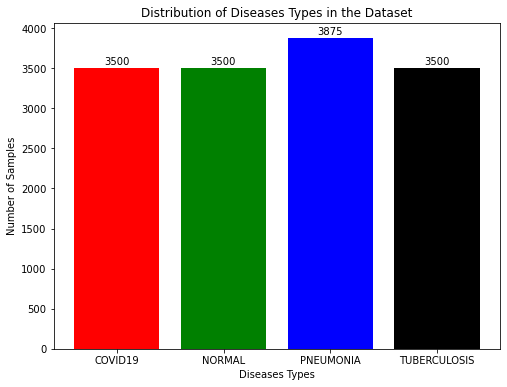

In [21]:
unique_labels, label_counts = np.unique(All_labels, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, label_counts, color=['red', 'green', 'blue', 'black'])
plt.xlabel('Diseases Types')
plt.ylabel('Number of Samples')
plt.title('Distribution of Diseases Types in the Dataset')
for i, count in enumerate(label_counts):
    plt.text(i, count + 20, str(count), ha='center', va='bottom')

plt.xticks(unique_labels, ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS' ])
plt.show()

In [22]:
# Normalize Pixel Values
All_data_normalized = All_data / 255.0

In [23]:
# Encode Labels
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(All_labels)
train_data, test_data, train_labels, test_labels = train_test_split(
    All_data_normalized, all_labels_encoded, test_size=0.15, random_state=42
)

In [24]:
image_size = (64, 64)
num_classes = 4

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.nn.tanh(tf.tensordot(x, self.W, axes=(2, 0)) + self.b)
        at = tf.nn.softmax(et, axis=1)
        ot = x * at
        return tf.reduce_sum(ot, axis=1)

In [26]:
from tensorflow.keras.models import Model
inputs = Input(shape=(image_size + (3,)))

x = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x) 
x = Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)

x = Reshape((1, -1))(x)

lstm_out = LSTM(50, return_sequences=True)(x)
lstm_out = Dropout(0.3)(lstm_out) 

attention_output = Attention()(lstm_out)

combined_output = Add()([attention_output, tf.reduce_sum(lstm_out, axis=1)])

outputs = Dense(num_classes, activation="softmax")(combined_output)

combined_model = Model(inputs=inputs, outputs=outputs)

combined_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

checkpoint_callback = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
early_stopping_callback = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)

# Model summary
combined_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 62, 62, 16)           448       ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 16)           0         ['conv2d_6[0][0]']            
 g2D)                                                                                             
                                                                                                  
 dropout_8 (Dropout)         (None, 31, 31, 16)           0         ['max_pooling2d_6[0][0]'

In [27]:
history = combined_model.fit(
    train_data,
    train_labels,
    epochs=20,
    batch_size=16,
    validation_split=0.15,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/20
649/650 [============================>.] - ETA: 0s - loss: 0.4301 - accuracy: 0.8307

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


650/650 [==============================] - 39s 54ms/step - loss: 0.4301 - accuracy: 0.8307 - val_loss: 0.2105 - val_accuracy: 0.9264
Epoch 2/20
650/650 [==============================] - 32s 50ms/step - loss: 0.2129 - accuracy: 0.9222 - val_loss: 0.1559 - val_accuracy: 0.9487
Epoch 3/20
650/650 [==============================] - 29s 45ms/step - loss: 0.1555 - accuracy: 0.9438 - val_loss: 0.1371 - val_accuracy: 0.9476
Epoch 4/20
650/650 [==============================] - 29s 44ms/step - loss: 0.1232 - accuracy: 0.9571 - val_loss: 0.1198 - val_accuracy: 0.9553
Epoch 5/20
650/650 [==============================] - 29s 44ms/step - loss: 0.0969 - accuracy: 0.9659 - val_loss: 0.1255 - val_accuracy: 0.9574
Epoch 6/20
650/650 [==============================] - 30s 46ms/step - loss: 0.0846 - accuracy: 0.9703 - val_loss: 0.0993 - val_accuracy: 0.9684
Epoch 7/20
650/650 [==============================] - 29s 45ms/step - loss: 0.0695 - accuracy: 0.9770 - val_loss: 0.1321 - val_accuracy: 0.9525
Epo

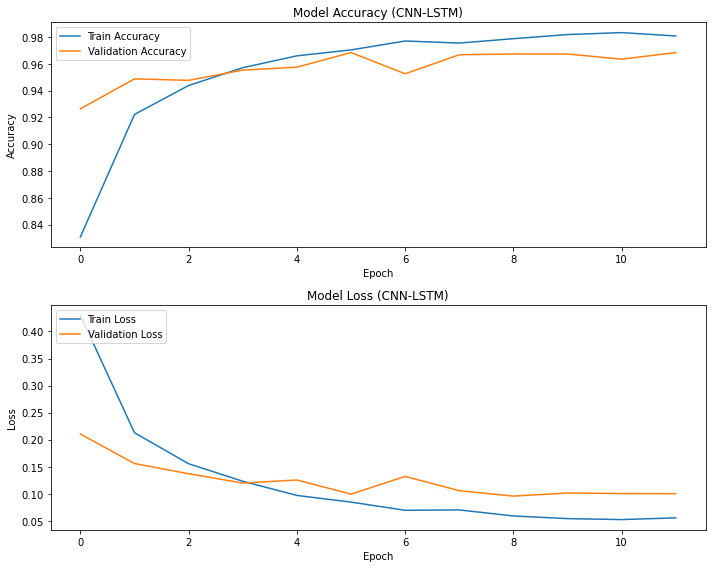

In [28]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot Accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy (CNN-LSTM)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='upper left')

# Plot Loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss (CNN-LSTM)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [29]:
# Evaluate the model on the test set
test_predictions1 = combined_model.predict(test_data)
test_predictions_classes1 = np.argmax(test_predictions1, axis=1)
CNN_LSTM_class_report1 = classification_report(test_labels, test_predictions_classes1, target_names=label_encoder.classes_)
print("Classification Report:\n", CNN_LSTM_class_report1)

68/68 [==============================] - 2s 18ms/step
Classification Report:
                precision    recall  f1-score   support

      COVID19       0.97      0.97      0.97       534
       NORMAL       0.98      0.97      0.97       520
    PNEUMONIA       0.97      0.98      0.97       604
TURBERCULOSIS       0.97      0.98      0.98       499

     accuracy                           0.97      2157
    macro avg       0.97      0.97      0.97      2157
 weighted avg       0.97      0.97      0.97      2157



In [30]:
accuracy = accuracy_score(test_labels, test_predictions_classes1)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 97.31%


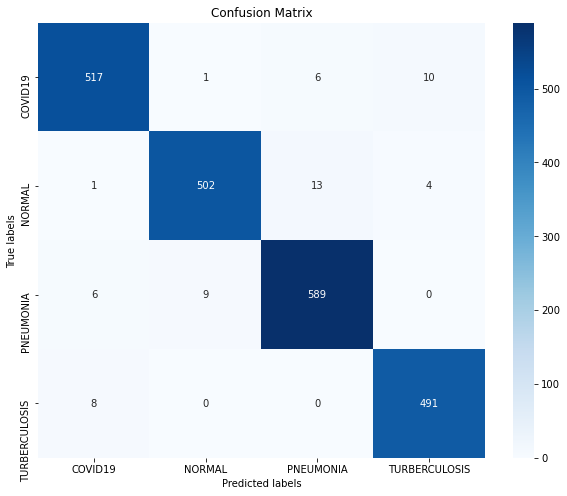

In [31]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_classes1)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [32]:
#combined_model.save("trained_combined_model_Attention.h5")

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
